In [1]:
import sys
sys.path.append("/home/aj/robosys24/BlueberryJam/src")

from Classifier import *
from preprocess_img import *
import cv2 as cv
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt

In [69]:
# hsv_lo = (70, 0, 0) # overripe - belt conditions
# hsv_hi = (180, 67, 100)

# hsv_lo = (80, 53, 0) # ripe - belt conditions
# hsv_hi = (180, 125, 105)

# hsv_lo = (0, 118, 0) # red/green - belt conditions
# hsv_hi = (180, 255, 150)
masks = [[(20, 0, 0), (180, 85, 65)],[(0, 60, 0), (38, 145, 100)],[(0, 135, 0), (180, 255, 150)]]
masks = [[(15,0,0),(180,215,255)],[(20, 0, 0), (180, 85, 65)],[(0, 60, 0), (38, 145, 100)],[(0, 135, 0), (180, 255, 150)]]
# [better overripe, ripe, all 3]

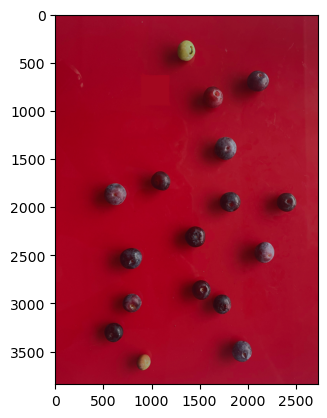

In [70]:
# Load the image
path = 'img/recolored_unripe_full1.jpg'
masked_imgs,img_rgb,mask_list = apply_multi_bg(masks,path)
plt.imshow(img_rgb)

(960, 682, 3)


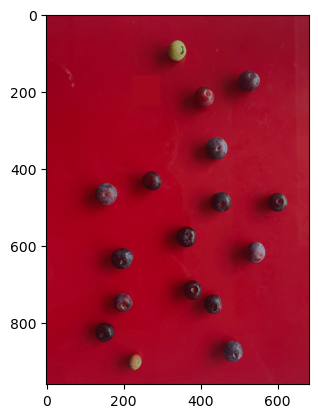

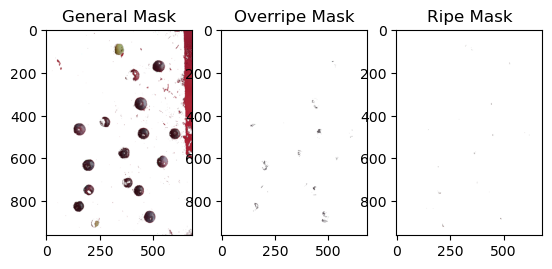

In [78]:
img_rgb = cv.resize(img_rgb, (682, 960), interpolation= cv.INTER_LINEAR)
plt.imshow(img_rgb)
masked_imgs[0] = cv.resize(masked_imgs[0], (682, 960), interpolation= cv.INTER_LINEAR)
masked_imgs[1] = cv.resize(masked_imgs[1], (682, 960), interpolation= cv.INTER_LINEAR)
masked_imgs[2] = cv.resize(masked_imgs[2], (682, 960), interpolation= cv.INTER_LINEAR)
masked_imgs[3] = cv.resize(masked_imgs[3], (682, 960), interpolation= cv.INTER_LINEAR)
masked_imgs[4] = cv.resize(masked_imgs[4], (682, 960), interpolation= cv.INTER_LINEAR)
b = np.shape(masked_imgs[0])
print(b)
white = np.full(b, 255, dtype=np.uint8)  # White image  

masked_imgs[0] = np.where(masked_imgs[0][:,:] == [0,0,0], white, masked_imgs[0])
masked_imgs[1] = np.where(masked_imgs[1][:,:] == [0,0,0], white, masked_imgs[1]) 
masked_imgs[2] = np.where(masked_imgs[2][:,:] == [0,0,0], white, masked_imgs[2])
masked_imgs[3] = np.where(masked_imgs[3][:,:] == [0,0,0], white, masked_imgs[3]) 
masked_imgs[4] = np.where(masked_imgs[4][:,:] == [0,0,0], white, masked_imgs[4])

plt.figure()
plt.subplot(1,3,1)
plt.title("General Mask")
plt.imshow(masked_imgs[0])
plt.subplot(1,3,2)
plt.title("Overripe Mask")
plt.imshow(masked_imgs[1])
plt.subplot(1,3,3)
plt.title("Ripe Mask")
plt.imshow(masked_imgs[2])
# plt.subplot(1,5,4)
# plt.imshow(masked_imgs[3])
# plt.subplot(1,5,5)
# plt.imshow(masked_imgs[3])
#cv.waitKey(0)

In [76]:
processed_imgs = []
centroid_results = []
existing_centroids = []
for i, img in enumerate(mask_list):
# overripe, ripe, underripe - i
#cv.waitKey(0)
    processed, centroids = perform_centroiding(img,img_rgb)
    processed_imgs.append(processed)

curr_mask_centroids = [(k[0], k[1]) for k in centroids] # (cX,cY)           
#compared centroids to centroid_results (keep in mind which mask should have priority (overripe))
# TODO: check if centroid is too close or the same as an existing centroid in another mask
if len(centroid_results) > 0: # only check duplicates if centroids already exist

    #intersections = set(existing_centroids) & set(curr_mask_centroids)
    for j in reversed(curr_mask_centroids):
        #print(f"existing centroids is {existing_centroids}")
        is_close = pythag_centroid(j,existing_centroids,thresh=7)

        if not is_close:
            continue
        #favors centroids already tracked (by extension overripe)
        #print(f"popping:{j}")
        idx = curr_mask_centroids.index(j)
        centroids.pop(idx)
        curr_mask_centroids.pop(idx)
existing_centroids.extend(curr_mask_centroids)            
centroid_results.append(centroids)

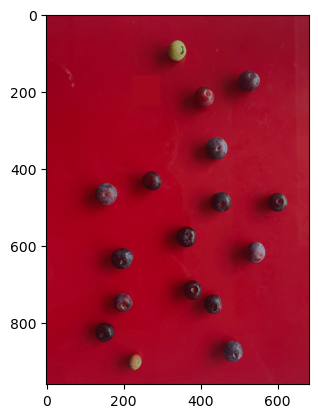

In [77]:
annotation_space = img_rgb.copy()
for i,centroid_list in enumerate(centroid_results):

    for centroid in centroid_list:
        loc = centroid[1]
        # berry = Blueberry(ripeness=0,belt=1,actuation_time=0.0,location_linear=abs(calculate_linear_location(loc)) )
        #overripe, ripe, underripe
        if i ==1:#ovveripe
            # berry.ripeness = 2
            similarities = [0.0,1.0,0.0] #ripe, overripe, underripe
            is_ripe =1
        elif i ==2: #ripe
            # berry.ripeness = 1
            similarities = [1.0,0.0,0.0]
            is_ripe = 0
        elif i ==3: #underripe
            # berry.ripeness = -1
            similarities = [0.0,0.0,1.0]
            is_ripe = 2
        else:
            similarities = [0.0,0.0,0.0]
            is_ripe = 0 #for full masked image

        #berry.ripeness = classify_single(img_rgb,annotation_space,centroid)
        # if berry.ripeness == -5:
        #     continue
        annotate_and_show(annotation_space,centroid,similarities,is_ripe)

plt.imshow(annotation_space)